# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:oracle.run2_limited",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.95616984
Average power, source: 1.0


Average magnitude, target: 0.8965841
Average power, target: 1.0


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 2520], examples_per_second: 126.8331, train_label_loss: 2.7729, 


epoch: 1, [batch: 252 / 2520], examples_per_second: 3170.6215, train_label_loss: 2.8182, 


epoch: 1, [batch: 504 / 2520], examples_per_second: 3207.4662, train_label_loss: 2.0160, 


epoch: 1, [batch: 756 / 2520], examples_per_second: 3190.2715, train_label_loss: 1.6416, 


epoch: 1, [batch: 1008 / 2520], examples_per_second: 3207.0268, train_label_loss: 1.6682, 


epoch: 1, [batch: 1260 / 2520], examples_per_second: 3189.8495, train_label_loss: 1.3977, 


epoch: 1, [batch: 1512 / 2520], examples_per_second: 3166.1404, train_label_loss: 1.5874, 


epoch: 1, [batch: 1764 / 2520], examples_per_second: 3163.8912, train_label_loss: 1.4270, 


epoch: 1, [batch: 2016 / 2520], examples_per_second: 3184.7390, train_label_loss: 1.4164, 


epoch: 1, [batch: 2268 / 2520], examples_per_second: 3188.1494, train_label_loss: 1.3451, 


epoch: 1, source_val_acc_label: 0.3953, target_val_acc_label: 0.2782, source_val_label_loss: 1.5238, target_val_label_loss: 1.9122, 


New best


epoch: 2, [batch: 1 / 2520], examples_per_second: 11.0831, train_label_loss: 1.8098, 


epoch: 2, [batch: 252 / 2520], examples_per_second: 3185.6855, train_label_loss: 1.2538, 


epoch: 2, [batch: 504 / 2520], examples_per_second: 3187.5930, train_label_loss: 1.2619, 


epoch: 2, [batch: 756 / 2520], examples_per_second: 3185.2447, train_label_loss: 1.1750, 


epoch: 2, [batch: 1008 / 2520], examples_per_second: 3196.2293, train_label_loss: 1.2617, 


epoch: 2, [batch: 1260 / 2520], examples_per_second: 3200.7138, train_label_loss: 1.2262, 


epoch: 2, [batch: 1512 / 2520], examples_per_second: 3204.4794, train_label_loss: 1.0477, 


epoch: 2, [batch: 1764 / 2520], examples_per_second: 3185.8087, train_label_loss: 1.3059, 


epoch: 2, [batch: 2016 / 2520], examples_per_second: 3220.2697, train_label_loss: 1.6126, 


epoch: 2, [batch: 2268 / 2520], examples_per_second: 3197.5315, train_label_loss: 0.9531, 


epoch: 2, source_val_acc_label: 0.4344, target_val_acc_label: 0.3056, source_val_label_loss: 1.3836, target_val_label_loss: 1.8394, 


New best


epoch: 3, [batch: 1 / 2520], examples_per_second: 11.1583, train_label_loss: 1.1864, 


epoch: 3, [batch: 252 / 2520], examples_per_second: 3169.7713, train_label_loss: 1.0546, 


epoch: 3, [batch: 504 / 2520], examples_per_second: 3195.2730, train_label_loss: 1.7002, 


epoch: 3, [batch: 756 / 2520], examples_per_second: 3196.6076, train_label_loss: 1.1163, 


epoch: 3, [batch: 1008 / 2520], examples_per_second: 3165.0032, train_label_loss: 1.2906, 


epoch: 3, [batch: 1260 / 2520], examples_per_second: 3180.7618, train_label_loss: 1.3026, 


epoch: 3, [batch: 1512 / 2520], examples_per_second: 3184.3425, train_label_loss: 1.4739, 


epoch: 3, [batch: 1764 / 2520], examples_per_second: 3170.5824, train_label_loss: 0.9536, 


epoch: 3, [batch: 2016 / 2520], examples_per_second: 3192.1406, train_label_loss: 0.7068, 


epoch: 3, [batch: 2268 / 2520], examples_per_second: 3182.6159, train_label_loss: 0.9299, 


epoch: 3, source_val_acc_label: 0.5395, target_val_acc_label: 0.4333, source_val_label_loss: 1.1961, target_val_label_loss: 1.5952, 


New best


epoch: 4, [batch: 1 / 2520], examples_per_second: 11.0741, train_label_loss: 0.6921, 


epoch: 4, [batch: 252 / 2520], examples_per_second: 3185.3485, train_label_loss: 1.0183, 


epoch: 4, [batch: 504 / 2520], examples_per_second: 3190.3171, train_label_loss: 0.9245, 


epoch: 4, [batch: 756 / 2520], examples_per_second: 3192.3818, train_label_loss: 0.7582, 


epoch: 4, [batch: 1008 / 2520], examples_per_second: 3184.8381, train_label_loss: 0.8532, 


epoch: 4, [batch: 1260 / 2520], examples_per_second: 3159.0751, train_label_loss: 1.2184, 


epoch: 4, [batch: 1512 / 2520], examples_per_second: 3154.7962, train_label_loss: 0.8326, 


epoch: 4, [batch: 1764 / 2520], examples_per_second: 3152.0506, train_label_loss: 0.7738, 


epoch: 4, [batch: 2016 / 2520], examples_per_second: 3188.8450, train_label_loss: 0.8668, 


epoch: 4, [batch: 2268 / 2520], examples_per_second: 3218.3965, train_label_loss: 0.8785, 


epoch: 4, source_val_acc_label: 0.5796, target_val_acc_label: 0.4694, source_val_label_loss: 1.1300, target_val_label_loss: 1.5420, 


New best


epoch: 5, [batch: 1 / 2520], examples_per_second: 11.0733, train_label_loss: 1.0847, 


epoch: 5, [batch: 252 / 2520], examples_per_second: 3190.3265, train_label_loss: 0.6041, 


epoch: 5, [batch: 504 / 2520], examples_per_second: 3185.5745, train_label_loss: 0.8303, 


epoch: 5, [batch: 756 / 2520], examples_per_second: 3199.4906, train_label_loss: 0.8510, 


epoch: 5, [batch: 1008 / 2520], examples_per_second: 3185.4141, train_label_loss: 1.2102, 


epoch: 5, [batch: 1260 / 2520], examples_per_second: 3191.7373, train_label_loss: 0.6811, 


epoch: 5, [batch: 1512 / 2520], examples_per_second: 3184.5132, train_label_loss: 0.7910, 


epoch: 5, [batch: 1764 / 2520], examples_per_second: 3196.2411, train_label_loss: 0.5728, 


epoch: 5, [batch: 2016 / 2520], examples_per_second: 3192.2898, train_label_loss: 0.8602, 


epoch: 5, [batch: 2268 / 2520], examples_per_second: 3204.2730, train_label_loss: 0.3860, 


epoch: 5, source_val_acc_label: 0.5950, target_val_acc_label: 0.4838, source_val_label_loss: 1.1484, target_val_label_loss: 1.5709, 


New best


epoch: 6, [batch: 1 / 2520], examples_per_second: 11.1012, train_label_loss: 0.5390, 


epoch: 6, [batch: 252 / 2520], examples_per_second: 3181.0479, train_label_loss: 0.6595, 


epoch: 6, [batch: 504 / 2520], examples_per_second: 3193.4969, train_label_loss: 0.5417, 


epoch: 6, [batch: 756 / 2520], examples_per_second: 3184.3130, train_label_loss: 0.2559, 


epoch: 6, [batch: 1008 / 2520], examples_per_second: 3181.1896, train_label_loss: 0.8496, 


epoch: 6, [batch: 1260 / 2520], examples_per_second: 3200.6466, train_label_loss: 0.6515, 


epoch: 6, [batch: 1512 / 2520], examples_per_second: 3188.7103, train_label_loss: 0.3594, 


epoch: 6, [batch: 1764 / 2520], examples_per_second: 3185.8762, train_label_loss: 0.3592, 


epoch: 6, [batch: 2016 / 2520], examples_per_second: 3193.9730, train_label_loss: 0.3283, 


epoch: 6, [batch: 2268 / 2520], examples_per_second: 3185.3472, train_label_loss: 0.5978, 


epoch: 6, source_val_acc_label: 0.6028, target_val_acc_label: 0.4899, source_val_label_loss: 1.1447, target_val_label_loss: 1.6009, 


New best


epoch: 7, [batch: 1 / 2520], examples_per_second: 11.1379, train_label_loss: 0.5570, 


epoch: 7, [batch: 252 / 2520], examples_per_second: 3191.9943, train_label_loss: 0.3998, 


epoch: 7, [batch: 504 / 2520], examples_per_second: 3203.6684, train_label_loss: 0.3457, 


epoch: 7, [batch: 756 / 2520], examples_per_second: 3203.7649, train_label_loss: 0.3657, 


epoch: 7, [batch: 1008 / 2520], examples_per_second: 3182.9171, train_label_loss: 0.3576, 


epoch: 7, [batch: 1260 / 2520], examples_per_second: 3199.9792, train_label_loss: 0.3723, 


epoch: 7, [batch: 1512 / 2520], examples_per_second: 3191.1814, train_label_loss: 0.5713, 


epoch: 7, [batch: 1764 / 2520], examples_per_second: 3177.9007, train_label_loss: 0.3852, 


epoch: 7, [batch: 2016 / 2520], examples_per_second: 3223.0419, train_label_loss: 0.4694, 


epoch: 7, [batch: 2268 / 2520], examples_per_second: 3208.7551, train_label_loss: 0.4879, 


epoch: 7, source_val_acc_label: 0.5964, target_val_acc_label: 0.4923, source_val_label_loss: 1.2702, target_val_label_loss: 1.7486, 


New best


epoch: 8, [batch: 1 / 2520], examples_per_second: 11.0677, train_label_loss: 0.2593, 


epoch: 8, [batch: 252 / 2520], examples_per_second: 3175.8716, train_label_loss: 0.2774, 


epoch: 8, [batch: 504 / 2520], examples_per_second: 3182.3633, train_label_loss: 0.3893, 


epoch: 8, [batch: 756 / 2520], examples_per_second: 3190.9762, train_label_loss: 0.3736, 


epoch: 8, [batch: 1008 / 2520], examples_per_second: 3190.1092, train_label_loss: 0.2534, 


epoch: 8, [batch: 1260 / 2520], examples_per_second: 3184.5461, train_label_loss: 0.4065, 


epoch: 8, [batch: 1512 / 2520], examples_per_second: 3206.7869, train_label_loss: 0.2941, 


epoch: 8, [batch: 1764 / 2520], examples_per_second: 3176.3541, train_label_loss: 0.2653, 


epoch: 8, [batch: 2016 / 2520], examples_per_second: 3197.7934, train_label_loss: 0.4243, 


epoch: 8, [batch: 2268 / 2520], examples_per_second: 3199.6284, train_label_loss: 0.3534, 


epoch: 8, source_val_acc_label: 0.5990, target_val_acc_label: 0.4910, source_val_label_loss: 1.3410, target_val_label_loss: 1.8269, 


epoch: 9, [batch: 1 / 2520], examples_per_second: 11.1776, train_label_loss: 0.3509, 


epoch: 9, [batch: 252 / 2520], examples_per_second: 3167.0335, train_label_loss: 0.3736, 


epoch: 9, [batch: 504 / 2520], examples_per_second: 3190.4589, train_label_loss: 0.2996, 


epoch: 9, [batch: 756 / 2520], examples_per_second: 3192.1227, train_label_loss: 0.3534, 


epoch: 9, [batch: 1008 / 2520], examples_per_second: 3173.4369, train_label_loss: 0.2741, 


epoch: 9, [batch: 1260 / 2520], examples_per_second: 3185.3972, train_label_loss: 0.2231, 


epoch: 9, [batch: 1512 / 2520], examples_per_second: 3183.7607, train_label_loss: 0.3755, 


epoch: 9, [batch: 1764 / 2520], examples_per_second: 3191.7671, train_label_loss: 0.4179, 


epoch: 9, [batch: 2016 / 2520], examples_per_second: 3189.8679, train_label_loss: 0.1718, 


epoch: 9, [batch: 2268 / 2520], examples_per_second: 3174.2720, train_label_loss: 0.3113, 


epoch: 9, source_val_acc_label: 0.6062, target_val_acc_label: 0.4915, source_val_label_loss: 1.3456, target_val_label_loss: 1.9125, 


epoch: 10, [batch: 1 / 2520], examples_per_second: 11.0930, train_label_loss: 0.5586, 


epoch: 10, [batch: 252 / 2520], examples_per_second: 3184.1852, train_label_loss: 0.2310, 


epoch: 10, [batch: 504 / 2520], examples_per_second: 3209.1146, train_label_loss: 0.5441, 


epoch: 10, [batch: 756 / 2520], examples_per_second: 3214.7098, train_label_loss: 0.5038, 


epoch: 10, [batch: 1008 / 2520], examples_per_second: 3188.5504, train_label_loss: 0.1145, 


epoch: 10, [batch: 1260 / 2520], examples_per_second: 3208.4561, train_label_loss: 0.3540, 


epoch: 10, [batch: 1512 / 2520], examples_per_second: 3203.5979, train_label_loss: 0.0785, 


epoch: 10, [batch: 1764 / 2520], examples_per_second: 3190.5991, train_label_loss: 0.1028, 


epoch: 10, [batch: 2016 / 2520], examples_per_second: 3193.6136, train_label_loss: 0.0599, 


epoch: 10, [batch: 2268 / 2520], examples_per_second: 3192.4876, train_label_loss: 0.2440, 


epoch: 10, source_val_acc_label: 0.5998, target_val_acc_label: 0.4970, source_val_label_loss: 1.5048, target_val_label_loss: 2.0510, 


New best


epoch: 11, [batch: 1 / 2520], examples_per_second: 11.0399, train_label_loss: 0.2453, 


epoch: 11, [batch: 252 / 2520], examples_per_second: 3192.8020, train_label_loss: 0.3746, 


epoch: 11, [batch: 504 / 2520], examples_per_second: 3186.9481, train_label_loss: 0.3200, 


epoch: 11, [batch: 756 / 2520], examples_per_second: 3202.8636, train_label_loss: 0.2556, 


epoch: 11, [batch: 1008 / 2520], examples_per_second: 3179.8719, train_label_loss: 0.5869, 


epoch: 11, [batch: 1260 / 2520], examples_per_second: 3205.5672, train_label_loss: 0.3299, 


epoch: 11, [batch: 1512 / 2520], examples_per_second: 3208.6194, train_label_loss: 0.1247, 


epoch: 11, [batch: 1764 / 2520], examples_per_second: 3180.8127, train_label_loss: 0.1769, 


epoch: 11, [batch: 2016 / 2520], examples_per_second: 3208.7245, train_label_loss: 0.3019, 


epoch: 11, [batch: 2268 / 2520], examples_per_second: 3198.3627, train_label_loss: 0.1374, 


epoch: 11, source_val_acc_label: 0.6084, target_val_acc_label: 0.4940, source_val_label_loss: 1.5588, target_val_label_loss: 2.1327, 


epoch: 12, [batch: 1 / 2520], examples_per_second: 11.1480, train_label_loss: 0.4307, 


epoch: 12, [batch: 252 / 2520], examples_per_second: 3184.6182, train_label_loss: 0.1057, 


epoch: 12, [batch: 504 / 2520], examples_per_second: 3193.2871, train_label_loss: 0.3641, 


epoch: 12, [batch: 756 / 2520], examples_per_second: 3202.7299, train_label_loss: 0.1268, 


epoch: 12, [batch: 1008 / 2520], examples_per_second: 3183.7511, train_label_loss: 0.0460, 


epoch: 12, [batch: 1260 / 2520], examples_per_second: 3182.5306, train_label_loss: 0.1204, 


epoch: 12, [batch: 1512 / 2520], examples_per_second: 3183.6585, train_label_loss: 0.1607, 


epoch: 12, [batch: 1764 / 2520], examples_per_second: 3157.4167, train_label_loss: 0.0273, 


epoch: 12, [batch: 2016 / 2520], examples_per_second: 3171.8369, train_label_loss: 0.1244, 


epoch: 12, [batch: 2268 / 2520], examples_per_second: 3178.0229, train_label_loss: 0.0957, 


epoch: 12, source_val_acc_label: 0.5990, target_val_acc_label: 0.4949, source_val_label_loss: 1.6263, target_val_label_loss: 2.2190, 


epoch: 13, [batch: 1 / 2520], examples_per_second: 11.1046, train_label_loss: 0.0886, 


epoch: 13, [batch: 252 / 2520], examples_per_second: 3184.0683, train_label_loss: 0.1924, 


epoch: 13, [batch: 504 / 2520], examples_per_second: 3183.9702, train_label_loss: 0.3353, 


epoch: 13, [batch: 756 / 2520], examples_per_second: 3184.0886, train_label_loss: 0.0827, 


epoch: 13, [batch: 1008 / 2520], examples_per_second: 3174.2554, train_label_loss: 0.3218, 


epoch: 13, [batch: 1260 / 2520], examples_per_second: 3178.5202, train_label_loss: 0.0345, 


epoch: 13, [batch: 1512 / 2520], examples_per_second: 3171.3577, train_label_loss: 0.1506, 


epoch: 13, [batch: 1764 / 2520], examples_per_second: 3193.6555, train_label_loss: 0.4516, 


epoch: 13, [batch: 2016 / 2520], examples_per_second: 3184.1625, train_label_loss: 0.0891, 


epoch: 13, [batch: 2268 / 2520], examples_per_second: 3175.6765, train_label_loss: 0.0507, 


epoch: 13, source_val_acc_label: 0.6025, target_val_acc_label: 0.4996, source_val_label_loss: 1.6362, target_val_label_loss: 2.2308, 


New best


epoch: 14, [batch: 1 / 2520], examples_per_second: 11.0701, train_label_loss: 0.0089, 


epoch: 14, [batch: 252 / 2520], examples_per_second: 3195.4595, train_label_loss: 0.4259, 


epoch: 14, [batch: 504 / 2520], examples_per_second: 3200.4304, train_label_loss: 0.2862, 


epoch: 14, [batch: 756 / 2520], examples_per_second: 3192.6306, train_label_loss: 0.4942, 


epoch: 14, [batch: 1008 / 2520], examples_per_second: 3200.4629, train_label_loss: 0.1299, 


epoch: 14, [batch: 1260 / 2520], examples_per_second: 3192.3539, train_label_loss: 0.0538, 


epoch: 14, [batch: 1512 / 2520], examples_per_second: 3188.8319, train_label_loss: 0.2550, 


epoch: 14, [batch: 1764 / 2520], examples_per_second: 3178.2472, train_label_loss: 0.2823, 


epoch: 14, [batch: 2016 / 2520], examples_per_second: 3179.3513, train_label_loss: 0.0435, 


epoch: 14, [batch: 2268 / 2520], examples_per_second: 3178.7029, train_label_loss: 0.0745, 


epoch: 14, source_val_acc_label: 0.6010, target_val_acc_label: 0.4965, source_val_label_loss: 1.6983, target_val_label_loss: 2.2997, 


epoch: 15, [batch: 1 / 2520], examples_per_second: 11.1161, train_label_loss: 0.4330, 


epoch: 15, [batch: 252 / 2520], examples_per_second: 3188.1240, train_label_loss: 0.0789, 


epoch: 15, [batch: 504 / 2520], examples_per_second: 3190.6547, train_label_loss: 0.0584, 


epoch: 15, [batch: 756 / 2520], examples_per_second: 3210.4347, train_label_loss: 0.1822, 


epoch: 15, [batch: 1008 / 2520], examples_per_second: 3179.9516, train_label_loss: 0.0181, 


epoch: 15, [batch: 1260 / 2520], examples_per_second: 3202.7562, train_label_loss: 0.1600, 


epoch: 15, [batch: 1512 / 2520], examples_per_second: 3196.3896, train_label_loss: 0.0380, 


epoch: 15, [batch: 1764 / 2520], examples_per_second: 3185.1979, train_label_loss: 0.1019, 


epoch: 15, [batch: 2016 / 2520], examples_per_second: 3188.8562, train_label_loss: 0.0214, 


epoch: 15, [batch: 2268 / 2520], examples_per_second: 3197.3954, train_label_loss: 0.1463, 


epoch: 15, source_val_acc_label: 0.6065, target_val_acc_label: 0.4987, source_val_label_loss: 1.7456, target_val_label_loss: 2.3505, 


epoch: 16, [batch: 1 / 2520], examples_per_second: 11.1447, train_label_loss: 0.0368, 


epoch: 16, [batch: 252 / 2520], examples_per_second: 3175.7019, train_label_loss: 0.2369, 


epoch: 16, [batch: 504 / 2520], examples_per_second: 3194.6572, train_label_loss: 0.0726, 


epoch: 16, [batch: 756 / 2520], examples_per_second: 3204.7164, train_label_loss: 0.1167, 


epoch: 16, [batch: 1008 / 2520], examples_per_second: 3188.5144, train_label_loss: 0.0144, 


epoch: 16, [batch: 1260 / 2520], examples_per_second: 3203.9465, train_label_loss: 0.0305, 


epoch: 16, [batch: 1512 / 2520], examples_per_second: 3198.4999, train_label_loss: 0.0283, 


epoch: 16, [batch: 1764 / 2520], examples_per_second: 3177.1326, train_label_loss: 0.0343, 


epoch: 16, [batch: 2016 / 2520], examples_per_second: 3184.0642, train_label_loss: 0.1323, 


epoch: 16, [batch: 2268 / 2520], examples_per_second: 3195.5910, train_label_loss: 0.0655, 


epoch: 16, source_val_acc_label: 0.6059, target_val_acc_label: 0.5004, source_val_label_loss: 1.7493, target_val_label_loss: 2.3821, 


New best


epoch: 17, [batch: 1 / 2520], examples_per_second: 11.0690, train_label_loss: 0.0461, 


epoch: 17, [batch: 252 / 2520], examples_per_second: 3167.6239, train_label_loss: 0.3256, 


epoch: 17, [batch: 504 / 2520], examples_per_second: 3205.6160, train_label_loss: 0.0671, 


epoch: 17, [batch: 756 / 2520], examples_per_second: 3206.5765, train_label_loss: 0.0093, 


epoch: 17, [batch: 1008 / 2520], examples_per_second: 3181.5595, train_label_loss: 0.3594, 


epoch: 17, [batch: 1260 / 2520], examples_per_second: 3188.4367, train_label_loss: 0.2187, 


epoch: 17, [batch: 1512 / 2520], examples_per_second: 3203.3428, train_label_loss: 0.1680, 


epoch: 17, [batch: 1764 / 2520], examples_per_second: 3174.8455, train_label_loss: 0.1251, 


epoch: 17, [batch: 2016 / 2520], examples_per_second: 3193.0748, train_label_loss: 0.2653, 


epoch: 17, [batch: 2268 / 2520], examples_per_second: 3197.2333, train_label_loss: 0.2762, 


epoch: 17, source_val_acc_label: 0.6005, target_val_acc_label: 0.5014, source_val_label_loss: 1.8440, target_val_label_loss: 2.5053, 


New best


epoch: 18, [batch: 1 / 2520], examples_per_second: 10.9245, train_label_loss: 0.1242, 


epoch: 18, [batch: 252 / 2520], examples_per_second: 3180.1874, train_label_loss: 0.0978, 


epoch: 18, [batch: 504 / 2520], examples_per_second: 3194.1405, train_label_loss: 0.0053, 


epoch: 18, [batch: 756 / 2520], examples_per_second: 3191.7600, train_label_loss: 0.1254, 


epoch: 18, [batch: 1008 / 2520], examples_per_second: 3179.7996, train_label_loss: 0.0646, 


epoch: 18, [batch: 1260 / 2520], examples_per_second: 3204.0879, train_label_loss: 0.3349, 


epoch: 18, [batch: 1512 / 2520], examples_per_second: 3193.7654, train_label_loss: 0.1059, 


epoch: 18, [batch: 1764 / 2520], examples_per_second: 3179.4905, train_label_loss: 0.2049, 


epoch: 18, [batch: 2016 / 2520], examples_per_second: 3187.7560, train_label_loss: 0.3413, 


epoch: 18, [batch: 2268 / 2520], examples_per_second: 3194.8540, train_label_loss: 0.0185, 


epoch: 18, source_val_acc_label: 0.6098, target_val_acc_label: 0.5043, source_val_label_loss: 1.8326, target_val_label_loss: 2.5212, 


New best


epoch: 19, [batch: 1 / 2520], examples_per_second: 11.0816, train_label_loss: 0.0511, 


epoch: 19, [batch: 252 / 2520], examples_per_second: 3173.6207, train_label_loss: 0.0629, 


epoch: 19, [batch: 504 / 2520], examples_per_second: 3196.9258, train_label_loss: 0.0819, 


epoch: 19, [batch: 756 / 2520], examples_per_second: 3205.2748, train_label_loss: 0.0673, 


epoch: 19, [batch: 1008 / 2520], examples_per_second: 3184.1745, train_label_loss: 0.0217, 


epoch: 19, [batch: 1260 / 2520], examples_per_second: 3181.3154, train_label_loss: 0.0312, 


epoch: 19, [batch: 1512 / 2520], examples_per_second: 3198.0827, train_label_loss: 0.0012, 


epoch: 19, [batch: 1764 / 2520], examples_per_second: 3164.0027, train_label_loss: 0.0463, 


epoch: 19, [batch: 2016 / 2520], examples_per_second: 3203.2001, train_label_loss: 0.0155, 


epoch: 19, [batch: 2268 / 2520], examples_per_second: 3214.5130, train_label_loss: 0.1453, 


epoch: 19, source_val_acc_label: 0.6096, target_val_acc_label: 0.5046, source_val_label_loss: 1.8748, target_val_label_loss: 2.5594, 


New best


epoch: 20, [batch: 1 / 2520], examples_per_second: 10.9915, train_label_loss: 0.0721, 


epoch: 20, [batch: 252 / 2520], examples_per_second: 3182.5572, train_label_loss: 0.0975, 


epoch: 20, [batch: 504 / 2520], examples_per_second: 3200.5993, train_label_loss: 0.0066, 


epoch: 20, [batch: 756 / 2520], examples_per_second: 3196.8918, train_label_loss: 0.2938, 


epoch: 20, [batch: 1008 / 2520], examples_per_second: 3191.0538, train_label_loss: 0.0598, 


epoch: 20, [batch: 1260 / 2520], examples_per_second: 3205.0583, train_label_loss: 0.1908, 


epoch: 20, [batch: 1512 / 2520], examples_per_second: 3200.6238, train_label_loss: 0.0737, 


epoch: 20, [batch: 1764 / 2520], examples_per_second: 3194.3734, train_label_loss: 0.2499, 


epoch: 20, [batch: 2016 / 2520], examples_per_second: 3196.4500, train_label_loss: 0.0027, 


epoch: 20, [batch: 2268 / 2520], examples_per_second: 3208.7673, train_label_loss: 0.1062, 


epoch: 20, source_val_acc_label: 0.6102, target_val_acc_label: 0.5028, source_val_label_loss: 1.9133, target_val_label_loss: 2.6144, 


epoch: 21, [batch: 1 / 2520], examples_per_second: 11.1038, train_label_loss: 0.0175, 


epoch: 21, [batch: 252 / 2520], examples_per_second: 3177.9987, train_label_loss: 0.1071, 


epoch: 21, [batch: 504 / 2520], examples_per_second: 3202.0418, train_label_loss: 0.0890, 


epoch: 21, [batch: 756 / 2520], examples_per_second: 3201.2710, train_label_loss: 0.0407, 


epoch: 21, [batch: 1008 / 2520], examples_per_second: 3193.5253, train_label_loss: 0.0856, 


epoch: 21, [batch: 1260 / 2520], examples_per_second: 3201.8515, train_label_loss: 0.0550, 


epoch: 21, [batch: 1512 / 2520], examples_per_second: 3198.3676, train_label_loss: 0.0034, 


epoch: 21, [batch: 1764 / 2520], examples_per_second: 3200.3224, train_label_loss: 0.0973, 


epoch: 21, [batch: 2016 / 2520], examples_per_second: 3182.4170, train_label_loss: 0.0059, 


epoch: 21, [batch: 2268 / 2520], examples_per_second: 3181.6468, train_label_loss: 0.0493, 


epoch: 21, source_val_acc_label: 0.6066, target_val_acc_label: 0.5055, source_val_label_loss: 1.9681, target_val_label_loss: 2.6962, 


New best


epoch: 22, [batch: 1 / 2520], examples_per_second: 11.0055, train_label_loss: 0.0589, 


epoch: 22, [batch: 252 / 2520], examples_per_second: 3169.9241, train_label_loss: 0.0176, 


epoch: 22, [batch: 504 / 2520], examples_per_second: 3191.8298, train_label_loss: 0.0232, 


epoch: 22, [batch: 756 / 2520], examples_per_second: 3208.4557, train_label_loss: 0.0037, 


epoch: 22, [batch: 1008 / 2520], examples_per_second: 3183.3421, train_label_loss: 0.0469, 


epoch: 22, [batch: 1260 / 2520], examples_per_second: 3180.7132, train_label_loss: 0.0092, 


epoch: 22, [batch: 1512 / 2520], examples_per_second: 3185.5040, train_label_loss: 0.1731, 


epoch: 22, [batch: 1764 / 2520], examples_per_second: 3182.2664, train_label_loss: 0.0240, 


epoch: 22, [batch: 2016 / 2520], examples_per_second: 3182.8354, train_label_loss: 0.0021, 


epoch: 22, [batch: 2268 / 2520], examples_per_second: 3198.6737, train_label_loss: 0.0027, 


epoch: 22, source_val_acc_label: 0.6002, target_val_acc_label: 0.4969, source_val_label_loss: 2.0143, target_val_label_loss: 2.7169, 


epoch: 23, [batch: 1 / 2520], examples_per_second: 11.2019, train_label_loss: 0.2203, 


epoch: 23, [batch: 252 / 2520], examples_per_second: 3183.9134, train_label_loss: 0.1719, 


epoch: 23, [batch: 504 / 2520], examples_per_second: 3197.7734, train_label_loss: 0.0388, 


epoch: 23, [batch: 756 / 2520], examples_per_second: 3189.7606, train_label_loss: 0.1608, 


epoch: 23, [batch: 1008 / 2520], examples_per_second: 3192.2205, train_label_loss: 0.0948, 


epoch: 23, [batch: 1260 / 2520], examples_per_second: 3187.3747, train_label_loss: 0.2364, 


epoch: 23, [batch: 1512 / 2520], examples_per_second: 3203.6089, train_label_loss: 0.0580, 


epoch: 23, [batch: 1764 / 2520], examples_per_second: 3191.3578, train_label_loss: 0.1450, 


epoch: 23, [batch: 2016 / 2520], examples_per_second: 3190.9033, train_label_loss: 0.0447, 


epoch: 23, [batch: 2268 / 2520], examples_per_second: 3209.7412, train_label_loss: 0.0247, 


epoch: 23, source_val_acc_label: 0.6107, target_val_acc_label: 0.5010, source_val_label_loss: 1.9779, target_val_label_loss: 2.6792, 


epoch: 24, [batch: 1 / 2520], examples_per_second: 11.1952, train_label_loss: 0.2096, 


epoch: 24, [batch: 252 / 2520], examples_per_second: 3196.8347, train_label_loss: 0.0204, 


epoch: 24, [batch: 504 / 2520], examples_per_second: 3174.2329, train_label_loss: 0.0073, 


epoch: 24, [batch: 756 / 2520], examples_per_second: 3207.4951, train_label_loss: 0.0452, 


epoch: 24, [batch: 1008 / 2520], examples_per_second: 3188.1863, train_label_loss: 0.4116, 


epoch: 24, [batch: 1260 / 2520], examples_per_second: 3182.4749, train_label_loss: 0.0287, 


epoch: 24, [batch: 1512 / 2520], examples_per_second: 3190.5752, train_label_loss: 0.1060, 


epoch: 24, [batch: 1764 / 2520], examples_per_second: 3183.8113, train_label_loss: 0.1284, 


epoch: 24, [batch: 2016 / 2520], examples_per_second: 3206.4876, train_label_loss: 0.0780, 


epoch: 24, [batch: 2268 / 2520], examples_per_second: 3181.9018, train_label_loss: 0.0846, 


epoch: 24, source_val_acc_label: 0.6049, target_val_acc_label: 0.5043, source_val_label_loss: 2.0049, target_val_label_loss: 2.6801, 


epoch: 25, [batch: 1 / 2520], examples_per_second: 11.0811, train_label_loss: 0.0655, 


epoch: 25, [batch: 252 / 2520], examples_per_second: 3198.9485, train_label_loss: 0.0174, 


epoch: 25, [batch: 504 / 2520], examples_per_second: 3209.2561, train_label_loss: 0.1156, 


epoch: 25, [batch: 756 / 2520], examples_per_second: 3206.6406, train_label_loss: 0.0035, 


epoch: 25, [batch: 1008 / 2520], examples_per_second: 3186.3132, train_label_loss: 0.0231, 


epoch: 25, [batch: 1260 / 2520], examples_per_second: 3205.7665, train_label_loss: 0.0542, 


epoch: 25, [batch: 1512 / 2520], examples_per_second: 3203.1479, train_label_loss: 0.1844, 


epoch: 25, [batch: 1764 / 2520], examples_per_second: 3175.7156, train_label_loss: 0.1358, 


epoch: 25, [batch: 2016 / 2520], examples_per_second: 3185.0503, train_label_loss: 0.0857, 


epoch: 25, [batch: 2268 / 2520], examples_per_second: 3184.6482, train_label_loss: 0.0056, 


epoch: 25, source_val_acc_label: 0.6115, target_val_acc_label: 0.5040, source_val_label_loss: 2.0251, target_val_label_loss: 2.7219, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

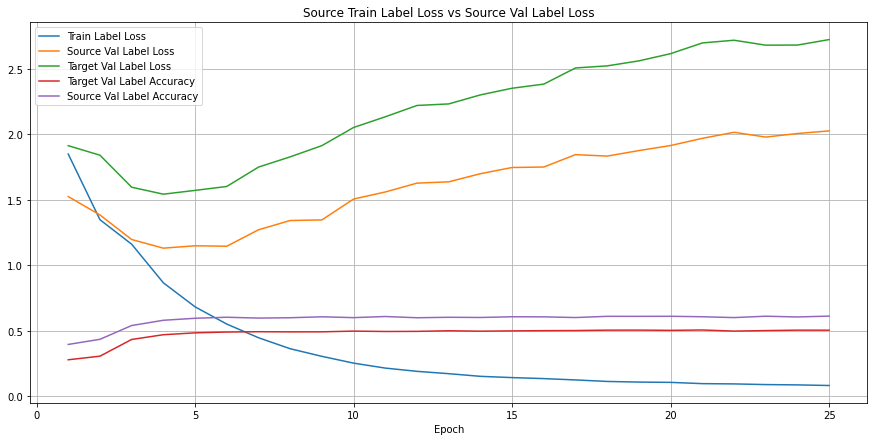

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

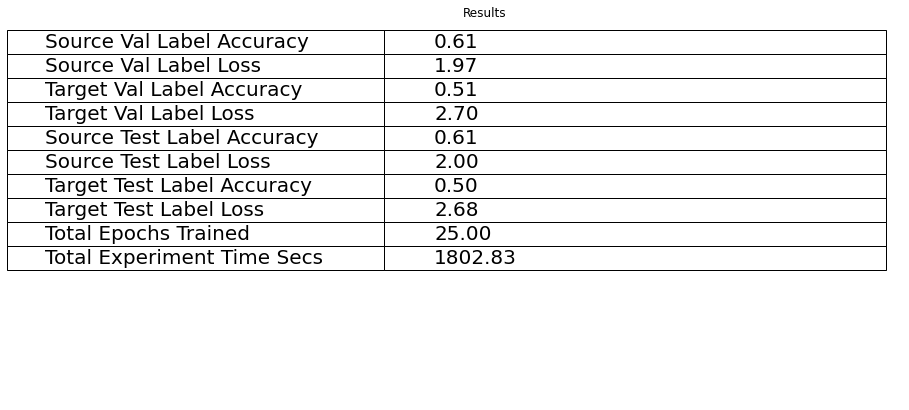

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

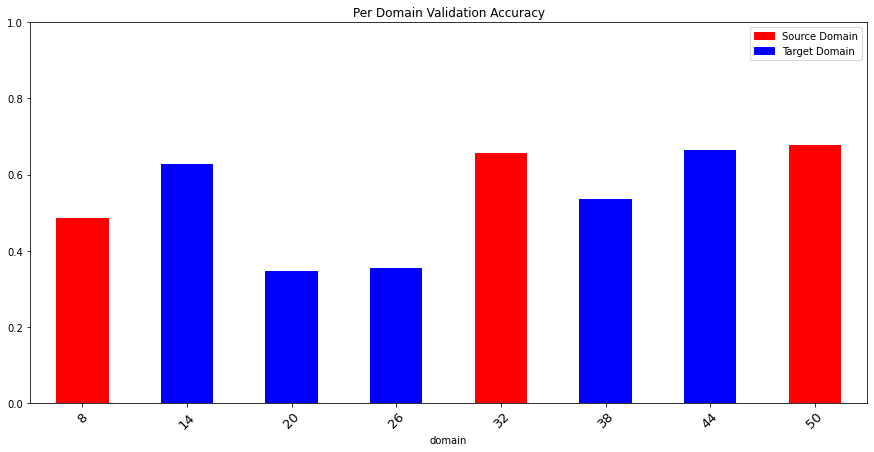

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.6059027777777778 Target Test Label Accuracy: 0.5025520833333333
Source Val Label Accuracy: 0.6065972222222222 Target Val Label Accuracy: 0.5055208333333333


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:oracle.run2_limited", "parameters": {"experiment_name": "tuned_1v2:oracle.run2_limited", "device": "cuda", "lr": 0.0001, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "episode_transforms_source": [], "episode_transforms_target": [], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [